In [1]:
import gymnasium as gym
env = gym.make('CartPole-v1')

In [2]:
%pip install swig
%pip install "gymnasium[box2d]"

import gymnasium as gym

env = gym.make("LunarLander-v3", render_mode="human")
observation, info = env.reset()

episode_over = False
while not episode_over:
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    episode_over = terminated or truncated

env.close()

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


error: XDG_RUNTIME_DIR not set in the environment.
libEGL warning: failed to open /dev/dri/renderD130: Permission denied

libEGL warning: failed to open /dev/dri/card3: Permission denied

libEGL warning: failed to open /dev/dri/renderD129: Permission denied

libEGL warning: failed to open /dev/dri/card2: Permission denied

libEGL warning: failed to open /dev/dri/renderD128: Permission denied

libEGL warning: failed to open /dev/dri/card1: Permission denied



In [3]:
import gymnasium as gym
from gymnasium.wrappers import FlattenObservation
env = gym.make("CarRacing-v3")
env.observation_space.shape
print(env.observation_space)
wrapped_env = FlattenObservation(env)
wrapped_env.observation_space.shape
print(wrapped_env.observation_space)

Box(0, 255, (96, 96, 3), uint8)
Box(0, 255, (27648,), uint8)


In [4]:
import gymnasium as gym

env = gym.make("Blackjack-v1")
observation, info = env.reset()

episode_over = False
while not episode_over:
    action = env.action_space.sample()  # 随机选择动作（此处仅为示例，应替换为智能体策略）
    next_observation, reward, terminated, truncated, info = env.step(action)

    print(f"动作: {action}, 奖励: {reward}, 终止: {terminated}, 截断: {truncated}")

    episode_over = terminated or truncated

env.close()

动作: 0, 奖励: -1.0, 终止: True, 截断: False


In [5]:
from collections import defaultdict
import gymnasium as gym
import numpy as np


class BlackjackAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [6]:
env = gym.make("Blackjack-v1")
agent = BlackjackAgent(
    env=env,
    learning_rate=0.1,
    initial_epsilon=1.0,
    epsilon_decay=0.001,
    final_epsilon=0.01,
)

for episode in range(1000):
    obs, info = env.reset()
    terminated = False
    truncated = False

    while not (terminated or truncated):
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.update(obs, action, reward, terminated, next_obs)
        obs = next_obs

    agent.decay_epsilon()

env.close()


# 禁用探索（完全利用）
agent.epsilon = 0.0

total_reward = 0
num_episodes = 100

for _ in range(num_episodes):
    obs, info = env.reset()
    terminated = False
    truncated = False

    while not (terminated or truncated):
        action = agent.get_action(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward

print(f"平均奖励：{total_reward / num_episodes}")

平均奖励：0.0


In [7]:


# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = gym.make("Blackjack-v1", sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [8]:


from tqdm import tqdm

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:12<00:00, 7977.21it/s]


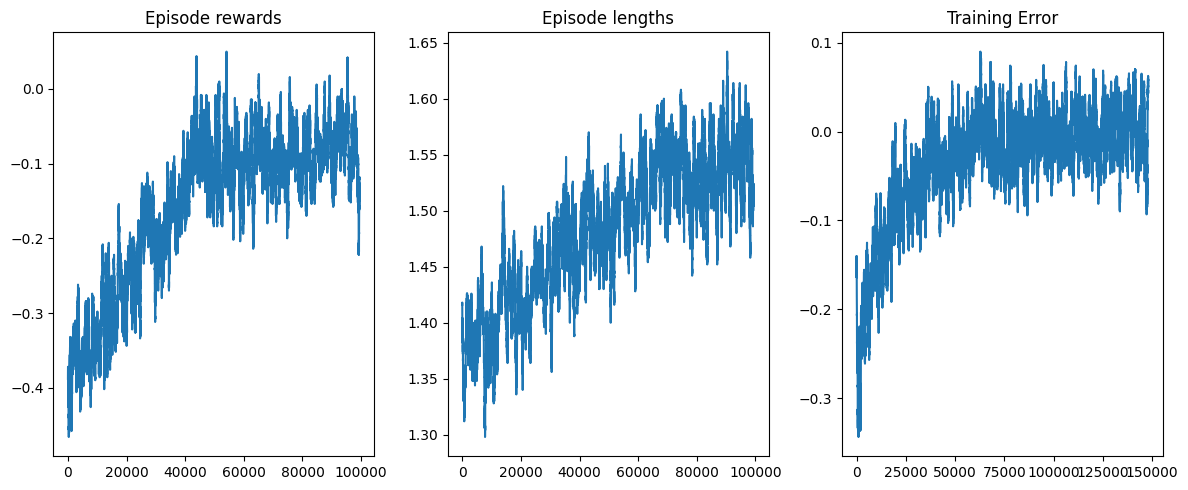

In [9]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500 episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()